# Getting started with Hyrax Custom Dataset Classes

In this notebook we are going to build up a custom dataset class for hyrax, and show how you can use the 
`prepare` verb in hyrax to test various aspects of your new dataclass.

First we will create some data in the form of 1000 random 10x10 tensors, fake filenames for these tensors:

In [27]:
import numpy as np
import torch

rng = np.random.default_rng()
num_tensors = 1000

# Generate filenames
alphabet = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
filename_length = 15
filenames = ["".join(list(rng.choice(alphabet, 15))) for _ in range(num_tensors)]

# Generate tensors
shape = (3, 10, 10)
random_data = {file: torch.from_numpy(rng.random(size=shape, dtype=np.float32)) for file in filenames}

## Building a custom Dataset class

We will treat these tensors as if they are on the filesystem, and write a dataclass that gives hyrax access to 
these "files" treating `_read_tensor` as a library function which returns a torch.Tensor from our "files", 
and `_list_filenames` as a library function which lists the filenames in a particular path.

The first thing we need to do is make a new class derived from HyraxDataset and torch.Dataset as shown below.

In [28]:
from torch.utils.data import Dataset
from hyrax.data_sets import HyraxDataset


class MyDataset(HyraxDataset, Dataset):
    def __init__(self, config: dict):
        self.filenames = MyDataset._list_filenames(config["general"]["data_dir"])
        super().__init__(config)

    def __getitem__(self, idx):
        return MyDataset._read_tensor(self.filenames[idx])

    def __len__(self):
        return len(self.filenames)

    @staticmethod
    def _list_filenames(path_to_data):
        """This is a pretend implementation so we ignore path_to_data"""
        global filenames
        return filenames

    @staticmethod
    def _read_tensor(filename):
        """Pretend to read a particular tensor from the disk."""
        global random_data
        return random_data[filename]

Key aspects of this class that you will need to replicate are:

* `__init__` must call `super().__init__(config)` This is important for hyrax to function appropriately, and 
gives you access to hyrax's config in other functions should you want it later. You will probably want to 
access `config["general"]["data_dir"]` to figure out what directory to start in.

* `__getitem__` You must implement this function, it takes an index and return the appropriate torch.Tensor
for your data.

* `__len__` must return the length of your tensorial data.

Note that all of these are instance methods that use `self` as the first argument. This `self` is the current
`MyDataset` object, and allows you to set and get values as is done with `self.filenames` in the code above.

The functions `_list_filenames()` and `_read_tensor()` are both reading our fake data, and are there so we 
have an effective demonstration. The functional organization of your analogous file reading code is entirely 
up to you!


We're now going to start up Hyrax and use the `prepare` verb to create an instance of this class and see
that it works correctly. Note that we have set `config["general]["data_dir"]` to specify the location of our
data for the `__init__`  function we wrote earlier, as well as the `config["data_set"]["name"]` to the 
name of our class, so that Hyrax knows to use our dataset class rather than one of the built-in ones.

Our `h.prepare()` line in the script will have the effect of calling our `__init__` function with the 
current hyrax config.

In [29]:
import hyrax

h = hyrax.Hyrax()
h.config["general"]["data_dir"] = "/fake/path/to/some/data"
h.config["data_set"]["name"] = "MyDataset"

dataset = h.prepare()

[2025-03-31 16:25:10,412 hyrax:INFO] Runtime Config read from: /Users/mtauraso/src/fibad/src/hyrax/hyrax_default_config.toml
[2025-03-31 16:25:10,413 hyrax.prepare:INFO] Finished Prepare


### Testing

The object we recieved from `h.prepare()` is an instance of our dataset, which we can test for functionality

We're going to index into the dataset object with `[]` this has the effect of calling our `__getitem__` function
and returning the result.

We're also going to call `len()` on the dataset which will have the effect of calling our `__len__` function

In [30]:
print("Checking __getitem__ ...", end="\n\n")
item = dataset[0]

print('Shape of our first element, should be "torch.Size([3,10,10])": ')
print(item.shape, end="\n\n")

print("Type of our first element, should be \"<class 'torch.Tensor'>\": ")
print(type(item), end="\n\n")

print("Checking __len__ ...\n\nShould print 0: ")
print(len(dataset))

Checking __getitem__ ...

Shape of our first element, should be "torch.Size([3,10,10])": 
torch.Size([3, 10, 10])

Type of our first element, should be "<class 'torch.Tensor'>": 
<class 'torch.Tensor'>

Checking __len__ ...

Should print 0: 
1000


This dataset class is suitable for training or inference with Hyrax; however, you may want to read on to learn
about more advanced features such as custom IDs for your data elements, metadata, and configuration access.

Below is a short example that uses the HyraxAutoencoder built-in model, demonstrating that training is possible:

In [31]:
import hyrax

h = hyrax.Hyrax()
h.config["general"]["data_dir"] = "/fake/path/to/some/data"
h.config["data_set"]["name"] = "MyDataset"
h.config["model"]["name"] = "HyraxAutoencoder"

h.train()

[2025-03-31 16:25:10,458 hyrax:INFO] Runtime Config read from: /Users/mtauraso/src/fibad/src/hyrax/hyrax_default_config.toml
[2025-03-31 16:25:10,465 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
2025-03-31 16:25:10,466 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.MyDataset': 
	{'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x3463927d0>, 'batch_size': 512, 'pin_memory': False}
2025-03-31 16:25:10,467 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.MyDataset': 
	{'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x346392860>, 'batch_size': 512, 'pin_memory': False}


2025/03/31 16:25:10 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/03/31 16:25:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
[2025-03-31 16:25:10,524 hyrax.pytorch_ignite:INFO] Training model on device: mps


 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

[2025-03-31 16:25:11,402 hyrax.pytorch_ignite:INFO] Total training time: 0.88[s]
[2025-03-31 16:25:11,402 hyrax.pytorch_ignite:INFO] Latest checkpoint saved as: /Users/mtauraso/src/fibad/docs/pre_executed/results/20250331-162510-train-rnY7/checkpoint_epoch_10.pt
[2025-03-31 16:25:11,403 hyrax.pytorch_ignite:INFO] Best metric checkpoint saved as: /Users/mtauraso/src/fibad/docs/pre_executed/results/20250331-162510-train-rnY7/checkpoint_9_loss=-26.0467.pt
2025/03/31 16:25:11 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/03/31 16:25:11 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-03-31 16:25:11,413 hyrax.train:INFO] Finished Training
[2025-03-31 16:25:11,675 hyrax.model_exporters:INFO] Exported model to ONNX format: /Users/mtauraso/src/fibad/docs/pre_executed/results/20250331-162510-train-rnY7/example_model_opset_20.onnx


## Extending to support visualization

This section is primarily concerned with binding different sorts of metadata to your dataset. This metadata
is used by the Hyrax visualization components to identify the source data of your latent space representation
and link it back to a particular object/event in your astronomical dataset. 

When we built `MyDataclass` above, we invisibly picked up two major aspects from `HyraxDataset`:

1. Unique IDs: Every tensor in our dataset got an ID of a sequential zero-based index, which was exactly the 
argument to `__getitem__`/`[]`. This list of ids is available as an iterator by calling `ids()` on the dataset
object. These IDs are used in inference results and visualizations of the data, but they can be overriden.

2. Metadata Interface: Every `HyraxDataset` can provide an astropy `Table` of values in the same order as 
their `__getitem__`/`[]` This allows each tensor in the dataset to have associated scalar data such as ra/dec, 
ephemeris parameters, redshift, magnitude, etc. For our class there currently is no metadata.

Below is how we would access the metadata and IDs demonstrating the default behavior if your custom class
does no overrides:

In [32]:
import hyrax

h = hyrax.Hyrax()
h.config["general"]["data_dir"] = "/fake/path/to/some/data"
h.config["data_set"]["name"] = "MyDataset"

dataset = h.prepare()

print("\nIDs:")
print(f"list(dataset.ids())[0:10] = {list(dataset.ids())[0:10]}")


print("\nMetadata field list:")
print(f"dataset.metadata_fields() = {dataset.metadata_fields()} (there is no metadata)")

[2025-03-31 16:25:11,703 hyrax:INFO] Runtime Config read from: /Users/mtauraso/src/fibad/src/hyrax/hyrax_default_config.toml
[2025-03-31 16:25:11,704 hyrax.prepare:INFO] Finished Prepare



IDs:
list(dataset.ids())[0:10] = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Metadata field list:
dataset.metadata_fields() = [] (there is no metadata)


### Adding IDs

We're going to use the filename in our fake data as IDs by adding a single `ids()` method to our `MyDataset` 
object. The most expedient way to do this will be to redefine the entire class below. Note that functions 
marked with a comment are just the same as earlier.

Note that the `ids()` function is required to return a generator, so we will use a `for` loop and `yield`
each sequential value. This interface allows Hyrax to partially enumerate the IDs in a dataset when that
is desirable. It is easy enough to get all the ids in order with `list(dataset.ids())`.

In [33]:
from torch.utils.data import Dataset
from hyrax.data_sets import HyraxDataset


class MyDataset(HyraxDataset, Dataset):
    def ids(self):
        for filename in self.filenames:
            yield filename

    # Unchanged from before below this comment ...
    def __init__(self, config: dict):
        self.filenames = MyDataset._list_filenames(config["general"]["data_dir"])
        super().__init__(config)

    def __getitem__(self, idx):
        return MyDataset._read_tensor(self.filenames[idx])

    def __len__(self):
        return len(self.filenames)

    @staticmethod
    def _list_filenames(path_to_data):
        """This is a pretend implementation so we ignore path_to_data"""
        global filenames
        return filenames

    @staticmethod
    def _read_tensor(filename):
        """Pretend to read a particular tensor from the disk."""
        global random_data
        return random_data[filename]

Running `prepare` again on our newly defined dataset class, we can see that the ids are now the fake 
"filenames" we generated at the top of the notebook, rather than sequential integers:

In [34]:
import hyrax

h = hyrax.Hyrax()
h.config["general"]["data_dir"] = "/fake/path/to/some/data"
h.config["data_set"]["name"] = "MyDataset"

dataset = h.prepare()

print("\nIDs:")
print(f"list(dataset.ids())[0:5] = {list(dataset.ids())[0:5]}")

[2025-03-31 16:25:11,735 hyrax:INFO] Runtime Config read from: /Users/mtauraso/src/fibad/src/hyrax/hyrax_default_config.toml
[2025-03-31 16:25:11,736 hyrax.prepare:INFO] Finished Prepare



IDs:
list(dataset.ids())[0:5] = ['KbxcaztWQglCwPm', 'lRGndoChowsKnDt', 'wkclElHQadPQjds', 'kHuuTuiVCCokNxk', 'PvrSyofbhGsNdQx']


### Adding Metadata

Now we are going to generate some fake metadata for our fake data. This will take the form of 
random ra/dec pairs for each fake object.

In [35]:
import astropy.units as u
from astropy.coordinates import SkyCoord

ras = rng.uniform(low=0.0, high=360.0, size=num_tensors) * u.deg
decs = rng.uniform(low=-90.0, high=90.0, size=num_tensors) * u.deg

In order to override metadata we will provide `HyraxDataset` with an astropy table containing all of the metadata in the constructor for our class as shown below. We do this in `__init__` by passing an astropy table of our metadata to `super().__init__` as a second, optional argument.

Note the new function `_read_metadata()` which constructs this table. On a real dataset this function would
most likely call astropy's `Table.read` [high level interface](https://docs.astropy.org/en/latest/io/unified.html) to construct a table directly from your catalog.

As before we re-implement the entire class below with small modifications marked with comments:

In [36]:
from torch.utils.data import Dataset
from hyrax.data_sets import HyraxDataset


class MyDataset(HyraxDataset, Dataset):
    def __init__(self, config: dict):
        self.filenames = MyDataset._list_filenames(config["general"]["data_dir"])
        metadata_table = MyDataset._read_metadata(config["general"]["data_dir"])
        super().__init__(config, metadata_table=metadata_table)

    def _read_metadata(path_to_data):
        """This is a pretend implementation so we don't use the path passed, which you might use
        to find your .csv/.fits/.tsv catalog file and call astropy's Table.read().

        We simply construct a table from our mock data"""
        from astropy.table import Table

        global ras, decs, filenames
        return Table({"object_id": filenames, "ra": ras, "dec": decs})

    # Unchanged from before below this comment ...
    def ids(self):
        for filename in self.filenames:
            yield filename

    def __getitem__(self, idx):
        return MyDataset._read_tensor(self.filenames[idx])

    def __len__(self):
        return len(self.filenames)

    @staticmethod
    def _list_filenames(path_to_data):
        """This is a pretend implementation so we ignore path_to_data"""
        global filenames
        return filenames

    @staticmethod
    def _read_tensor(filename):
        """Pretend to read a particular tensor from the disk."""
        global random_data
        return random_data[filename]

Now that our dataset class supports metadata, we can access the metadata interface directly on the dataset object using the `metadata_fields` and `metadata` functions on the dataset object.

- `metadata_fields` lists the available fields, in our case only "ra" and "dec" are available, but 
this is only because that is what was defined in the cell above
- `metadata` takes a list (or array) of indexes, and a list (or array) of valid fields. It returns a numpy rec-array of the selected metadata fields for the selected data indexes. It is essentially
equivalent to `metadata_table[indexes][fields].as_array()` where `metadata_table` is the original astropy table.

In [ ]:
import hyrax
from astropy.table import Table

h = hyrax.Hyrax()
h.config["general"]["data_dir"] = "/fake/path/to/some/data"
h.config["data_set"]["name"] = "MyDataset"

dataset = h.prepare()

print("\nMetadata field list:")
print(f"dataset.metadata_fields() = {dataset.metadata_fields()}")
print(f'Table(dataset.metadata([1, 3, 4], "ra")) =>')
Table(dataset.metadata([1, 3, 4], ["ra"]))

[2025-03-31 16:25:11,780 hyrax:INFO] Runtime Config read from: /Users/mtauraso/src/fibad/src/hyrax/hyrax_default_config.toml
[2025-03-31 16:25:11,782 hyrax.prepare:INFO] Finished Prepare



Metadata field list:
dataset.metadata_fields() = ['object_id', 'ra', 'dec']
Table(dataset.metadata([1,2], "ra")) =>


<Table length=3>
        ra        
     float64      
------------------
 57.53980945647574
 60.44288956543991
276.84465597293746

Now that we have a Dataset capable of 'ra' and 'dec' metadata, we can do a full analysis with hyrax, `train`ing the model, `infer`ing the latent space,`umap`ping the latent space to a 2d representation, and `visualize`-ing the result.

At time of writing `visualize` requres "object_id", "ra" and "dec" fields to be defined in order to work at all. Note the appearance of those same fields in the visualizer table to the immediate right of the "x" and "y" values for the 2d projected latent space.

[2025-03-31 16:25:11,843 hyrax:INFO] Runtime Config read from: /Users/mtauraso/src/fibad/src/hyrax/hyrax_default_config.toml
[2025-03-31 16:25:11,849 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
2025-03-31 16:25:11,853 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.MyDataset': 
	{'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x33da61060>, 'batch_size': 512, 'pin_memory': False}
2025-03-31 16:25:11,855 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.MyDataset': 
	{'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x33feca110>, 'batch_size': 512, 'pin_memory': False}
2025/03/31 16:25:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/03/31 16

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

 50%|#####     | 1/2 [00:00<?, ?it/s]

[2025-03-31 16:25:12,754 hyrax.pytorch_ignite:INFO] Total training time: 0.86[s]
[2025-03-31 16:25:12,754 hyrax.pytorch_ignite:INFO] Latest checkpoint saved as: /Users/mtauraso/src/fibad/docs/pre_executed/results/20250331-162511-train-xt1_/checkpoint_epoch_10.pt
[2025-03-31 16:25:12,754 hyrax.pytorch_ignite:INFO] Best metric checkpoint saved as: /Users/mtauraso/src/fibad/docs/pre_executed/results/20250331-162511-train-xt1_/checkpoint_10_loss=-28.2498.pt
2025/03/31 16:25:12 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/03/31 16:25:12 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-03-31 16:25:12,764 hyrax.train:INFO] Finished Training
[2025-03-31 16:25:12,955 hyrax.model_exporters:INFO] Exported model to ONNX format: /Users/mtauraso/src/fibad/docs/pre_executed/results/20250331-162511-train-xt1_/example_model_opset_20.onnx
[2025-03-31 16:25:12,959 hyrax.models.model_registry:INFO] 

Creating lower dimensional representation using UMAP::   0%|          | 0/2 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[2025-03-31 16:25:20,932 hyrax.data_sets.inference_dataset:INFO] Using most recent results dir /Users/mtauraso/src/fibad/docs/pre_executed/results/20250331-162513-umap-l7ZZ for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
[2025-03-31 16:25:20,956 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-03-31 16:25:20,957 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-03-31 16:25:20,957 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
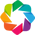

BokehModel(combine_events=True, render_bundle={'docs_json': {'d5faa32b-733c-41b5-8278-cc354a18b40e': {'version…

In [38]:
import hyrax

h = hyrax.Hyrax()
h.config["general"]["data_dir"] = "/fake/path/to/some/data"
h.config["data_set"]["name"] = "MyDataset"
h.config["model"]["name"] = "HyraxAutoencoder"

h.train()
h.infer()
h.umap()
h.visualize()